In [1]:
import muq.Modeling as mm # import MUQ modeling module
import muq.SamplingAlgorithms as ms # import MUQ SamplingAlgorithms module
import numpy as np

import matplotlib.pyplot as plt

In [2]:
mux = np.array([1.0])
varx = np.array([0.5])

# Create the joint log density, which will have two inputs with sizes [1,2]
px = mm.Gaussian(mux,varx).AsDensity()

muy = np.array([-1.0,-1.0])
vary = np.array([1.0,2.0])

py = mm.Gaussian(muy,vary).AsDensity()

graph = mm.WorkGraph()
graph.AddNode(px, "p(x)")
graph.AddNode(py, "p(y)")
graph.AddNode(mm.DensityProduct(2), "p(x,y)")
graph.AddEdge("p(x)",0,"p(x,y)",0)
graph.AddEdge("p(y)",0,"p(x,y)",1)

# Create the joint log density, which will have two inputs with sizes [1,2]
pxy = graph.CreateModPiece("p(x,y)")

In [3]:
# Define the sampling problem 
problem = ms.SamplingProblem(pxy)

# Construct the proposal on x
opts = {
        "ProposalVariance": 3.0,
        "BlockIndex" : 0 # Specify that this proposal should target x
       }

propx = ms.MHProposal(opts, problem)

# Construct the proposal on y
opts = {
        "ProposalVariance": 5.0,
        "BlockIndex": 1
       }

propy = ms.MHProposal(opts, problem)

# Construct the MCMC sampler using this transition kernel
kernels = [ms.MHKernel({}, problem, propx),
           ms.MHKernel({}, problem, propy)]


In [4]:
opts = {
    "NumSamples" : 4000,
    "BurnIn" : 10,
    "PrintLevel" : 0
}

# Run 4 independent chains to help assess convergence
numChains = 4

chains = [None]*numChains

for i in range(numChains):
    startPt = [ np.random.randn(1), # initial value for x
                2.0*np.random.randn(2) ] # initial value for y
    
    sampler = ms.SingleChainMCMC(opts, kernels)
    chains[i] = sampler.Run(startPt)

# Compute the Rhat convergence diagnostic
rhat = ms.Diagnostics.Rhat(chains)
print('Rhat = ', rhat)

# Estimate the total effective sample size
ess = chains[0].ESS()
for chain in chains[1:]:
    ess += chain.ESS()
    
print('ESS = ', ess)

Rhat =  [1.00291239 1.00261598 1.00346293]
ESS =  [2010.01652736 1439.68679382 1046.02164043]


# Visualize the chain
Here we create trace plots for the first MCMC chain.

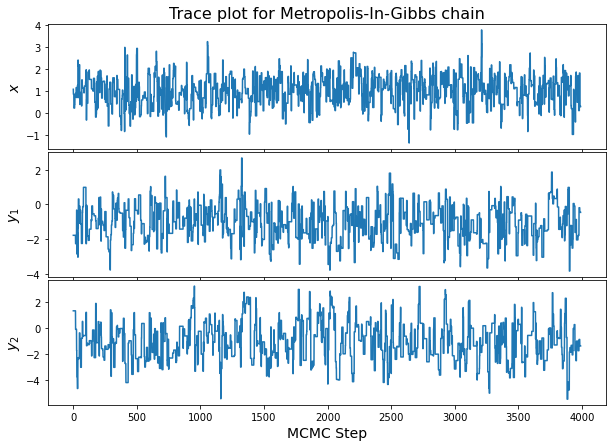

In [5]:
fig, axs = plt.subplots(figsize=(10,7),nrows=3, sharex=True)

sampMat = chains[0].AsMatrix()
axs[0].plot(sampMat[0,:])
axs[1].plot(sampMat[1,:])
axs[2].plot(sampMat[2,:])
    
axs[0].set_ylabel('$x$',fontsize=14)
axs[1].set_ylabel('$y_1$',fontsize=14)
axs[2].set_ylabel('$y_2$',fontsize=14)

axs[2].set_xlabel('MCMC Step',fontsize=14)

axs[0].set_title('Trace plot for Metropolis-In-Gibbs chain',fontsize=16)

plt.subplots_adjust(hspace=0.03)